In [86]:
import sys
import sklearn

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib.pyplot as plt

# Char-RNN

## Splitting a sequence into batches of shuffled windows

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps=5
dataset =tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" *5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text =f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer= keras.preprocessing.text.Tokenizer(char_level =True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20,6,9,8,3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count

In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) -1
train_size = dataset_size *90 //100
dataset= tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [11]:
n_steps = 100
window_length = n_steps +1
dataset = dataset.window(window_length, shift=1, drop_remainder =True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size =32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

In [18]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [19]:
model = keras.models.Sequential([keras.layers.GRU(128, return_sequences=True, input_shape = [None, max_id], 
                                                  # dropout=0.2, recurrent_dropout=0.2,
                                                  dropout =0.2),
                                 keras.layers.GRU(128, return_sequences=True,
                                                  # dropout=0.2, recurrent_dropout=0.2,
                                                  dropout =0.2),
                                 keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
                                ])
model.compile(loss="sparse_categorical_crossentropy", optimizer ="adam")
history= model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 200s 6ms/step - loss: 1.6214
Epoch 2/10
31368/31368 [==============================] - 197s 6ms/step - loss: 1.5321
Epoch 3/10
31368/31368 [==============================] - 197s 6ms/step - loss: 1.5103
Epoch 4/10
31368/31368 [==============================] - 197s 6ms/step - loss: 1.4995
Epoch 5/10
31368/31368 [==============================] - 197s 6ms/step - loss: 1.4924
Epoch 6/10
31368/31368 [==============================] - 197s 6ms/step - loss: 1.4873
Epoch 7/10
31368/31368 [==============================] - 197s 6ms/step - loss: 1.4835
Epoch 8/10
31368/31368 [==============================] - 198s 6ms/step - loss: 1.4804
Epoch 9/10
31368/31368 [==============================] - 197s 6ms/step - loss: 1.4778
Epoch 10/10
31368/31368 [==============================] - 199s 6ms/step - loss: 1.4757


## Using the Model to Generate Text

In [20]:
def preprocess(texts):
    X=np.array(tokenizer.texts_to_sequences(texts))-1
    return tf.one_hot(X, max_id)

In [21]:
X_new=preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred+1)[0][-1]

'u'

In [22]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [23]:
def next_char(text, temperature=1):
    X_new=preprocess([text])
    y_proba=model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba)/ temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)+1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [24]:
tf.random.set_seed(42)
next_char("How are yo", temperature=1)

'u'

In [25]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [26]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the words?

petruchio:
sir, i promised the rest and


In [27]:
print(complete_text("t", temperature=1))

to co broight you myself 

petruchio:
virona, for y


In [28]:
print(complete_text("t", temperature=2))

tpeniomem lace? till he'll je'er;
thenid ruch-faper


# Stateful RNN

In [29]:
tf.random.set_seed(42)

In [30]:
dataset= tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset=dataset.flat_map(lambda window: window.batch(window_length))
dataset=dataset.batch(1)
dataset=dataset.map(lambda windows:(windows[:,:-1], windows[:, 1:]))
dataset =dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset =dataset.prefetch(1)

In [31]:
batch_size=32
encoded_parts=np.array_split(encoded[:train_size], batch_size)
datasets=[]
for encoded_part in encoded_parts:
    dataset =tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset=dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset= dataset.map(lambda windows: (windows[:,:-1], windows[:,1:]))
dataset = dataset.map(lambda X_batch, Y_batch:(tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [32]:
model = keras.models.Sequential([keras.layers.GRU(128, return_sequences=True, stateful=True, 
                                                  # dropout=0.2, recurrent_dropout=0.2,
                                                  dropout =0.2, 
                                                  batch_input_shape=[batch_size, None, max_id]),
                                 keras.layers.GRU(128, return_sequences=True,stateful =True,
                                                  # dropout=0.2, recurrent_dropout=0.2,
                                                  dropout =0.2),
                                 keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
                                ])

In [33]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer ="adam")
history= model.fit(dataset, epochs=50, 
                  callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 4s 6ms/step - loss: 2.6211
Epoch 2/50
313/313 [==============================] - 2s 6ms/step - loss: 2.2422
Epoch 3/50
313/313 [==============================] - 2s 6ms/step - loss: 2.1109
Epoch 4/50
313/313 [==============================] - 2s 6ms/step - loss: 2.0358
Epoch 5/50
313/313 [==============================] - 2s 6ms/step - loss: 1.9854
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 1.9480
Epoch 7/50
313/313 [==============================] - 2s 6ms/step - loss: 1.9206
Epoch 8/50
313/313 [==============================] - 2s 6ms/step - loss: 1.8991
Epoch 9/50
313/313 [==============================] - 2s 6ms/step - loss: 1.8817
Epoch 10/50
313/313 [==============================] - 2s 6ms/step - loss: 1.8661
Epoch 11/50
313/313 [==============================] - 2s 6ms/step - loss: 1.8533
Epoch 12/50
313/313 [==============================] - 2s 6ms/step - loss: 1.8419
Epoch 13/50
313/313 [====

In [35]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape = [None, max_id] ),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
    ])


In [36]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [37]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [38]:
tf.random.set_seed(42)
print(complete_text("t"))

thing addidness of a jisuve,
by his paunt too stand


# Sentiment Analysis

In [39]:
tf.random.set_seed(42)

In [40]:
(X_train, y_train), (X_test, y_test)= keras.datasets.imdb.load_data()

17464789/17464789 [==============================] - 1s 0us/step


In [41]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [42]:
word_index=keras.datasets.imdb.get_word_index()
id_to_word={id_+3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1641221/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [43]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

2023-08-02 07:48:02.216611: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /home/tuffy/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [44]:
datasets.keys()

dict_keys([Split('train'), Split('test'), Split('unsupervised')])

In [45]:
train_size= info.splits["train"].num_examples
test_size =info.splits["test"].num_examples

In [46]:
train_size, test_size

(25000, 25000)

In [47]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "=Positive" if label else "=Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 =Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 =Negative



2023-08-02 07:48:44.853473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [48]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch
    

In [49]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [50]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [51]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [52]:
len(vocabulary)

53893

In [53]:
vocab_size= 10000
truncated_vocabulary=[word for word, count in vocabulary.most_common()[:vocab_size]]

In [54]:
word_to_id= {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [55]:
words = tf.constant(truncated_vocabulary)
word_ids=tf.range(len(truncated_vocabulary),dtype = tf.int64)
vocab_init= tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets =1000
table= tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [56]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [57]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [59]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [60]:
embed_size = 128
model = keras.models.Sequential([keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, 
                                                        mask_zero = True,
                                                        input_shape =[None]),
                                keras.layers.GRU(128, return_sequences= True), 
                                keras.layers.GRU(128), 
                                keras.layers.Dense(1, activation = "sigmoid")])
model.compile(loss= "binary_crossentropy", optimizer = "adam", metrics= ["accuracy"])
history= model.fit(train_set, epochs= 5)

Epoch 1/5


2023-08-02 09:28:52.705639: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_22'


782/782 [==============================] - 10s 6ms/step - loss: 0.5305 - accuracy: 0.7280
Epoch 2/5
782/782 [==============================] - 5s 6ms/step - loss: 0.3458 - accuracy: 0.8550
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: 0.1935 - accuracy: 0.9312
Epoch 4/5
782/782 [==============================] - 5s 6ms/step - loss: 0.1367 - accuracy: 0.9504
Epoch 5/5
782/782 [==============================] - 5s 6ms/step - loss: 0.1036 - accuracy: 0.9636


In [62]:
K =keras.backend
embed_size = 128
inputs = keras.layers.Input(shape= [None])
mask =keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z= keras.layers.GRU(128, return_sequences= True)(z, mask = mask)
z = keras.layers.GRU(128)(z, mask =mask)
outputs = keras.layers.Dense(1, activation = "sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs= [outputs])
model.compile(loss= "binary_crossentropy", optimizer = "adam", metrics= ["accuracy"])
history= model.fit(train_set, epochs= 5)

Epoch 1/5
782/782 [==============================] - 10s 6ms/step - loss: 0.5373 - accuracy: 0.7185
Epoch 2/5
782/782 [==============================] - 5s 6ms/step - loss: 0.3438 - accuracy: 0.8564
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: 0.1892 - accuracy: 0.9317
Epoch 4/5
782/782 [==============================] - 5s 6ms/step - loss: 0.1336 - accuracy: 0.9522
Epoch 5/5
782/782 [==============================] - 5s 6ms/step - loss: 0.1092 - accuracy: 0.9608


## Reusing Pretrained Embeddings

In [63]:
tf.random.set_seed(42)

In [64]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"]=TFHUB_CACHE_DIR

In [66]:
import tensorflow_hub as hub

model = keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", 
                                       dtype =tf.string, input_shape=[], output_shape=[50]),
                        keras.layers.Dense(128, activation="relu"),
                        keras.layers.Dense(1, activation="sigmoid")])
model.compile(loss="binary_crossentropy", optimizer ="adam", metrics=["accuracy"])

In [67]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001


In [68]:
import tensorflow_datasets as tfds

datasets, info =tfds.load("imdb_reviews", as_supervised=True, with_info= True)
train_size = info.splits["train"].num_examples
batch_size= 32
train_set= datasets["train"].batch(batch_size).prefetch(1)
history=model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 2s 2ms/step - loss: 0.5461 - accuracy: 0.7267
Epoch 2/5
782/782 [==============================] - 1s 2ms/step - loss: 0.5130 - accuracy: 0.7495
Epoch 3/5
782/782 [==============================] - 1s 2ms/step - loss: 0.5081 - accuracy: 0.7532
Epoch 4/5
782/782 [==============================] - 1s 2ms/step - loss: 0.5047 - accuracy: 0.7540
Epoch 5/5
782/782 [==============================] - 1s 2ms/step - loss: 0.5018 - accuracy: 0.7566


## Automatic Translation

In [69]:
tf.random.set_seed(42)

In [70]:
vocab_size= 100
embed_size=10

In [75]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings= keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings= embeddings(encoder_inputs)
decoder_embeddings= embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state= True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state= [state_h, state_c]

sampler= tfa.seq2seq.sampler.TrainingSampler()

decoder_cell= keras.layers.LSTMCell(512)
output_layer= keras.layers.Dense(vocab_size)
decoder= tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer= output_layer)
final_outputs, final_state, final_sequence_lengths= decoder(
    decoder_embeddings, initial_state= encoder_state, 
    sequence_length= sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model= keras.models.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths], outputs= [Y_proba])

In [76]:
model.compile(loss= "sparse_categorical_crossentropy", optimizer= "adam")

In [77]:
X=np.random.randint(100, size= 10*1000).reshape(1000, 10)
Y=np.random.randint(100, size= 15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000,1)), Y[:,:-1]]
seq_lengths = np.full([1000],15)

history= model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 3s 12ms/step - loss: 4.6052
Epoch 2/2
32/32 [==============================] - 0s 12ms/step - loss: 4.6037


### Bidirectional Recurrent Layers

In [78]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape = [None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences= True))])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, None, 10)          660       
                                                                 
 bidirectional (Bidirectiona  (None, None, 20)         1320      
 l)                                                              
                                                                 
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [92]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims %2 == 1: max_dims +=1
        p, i=  np.meshgrid(np.arange(max_steps), np.arange(max_dims //2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :,::2] = np.sin(p / 10000 ** (2 *i / max_dims)).T
        pos_emb[0, :,1::2] = np.cos(p / 10000 ** (2 *i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape= tf.shape(inputs)
        return inputs+ self.positional_embedding[:, :shape[-2], :shape[-1]]

In [93]:
max_steps=201
max_dims =512
pos_emb= PositionalEncoding(max_steps, max_dims)
PE=pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

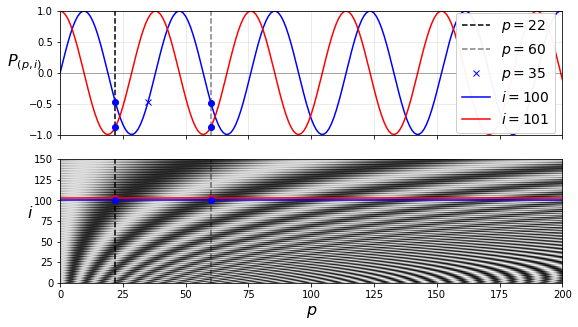

In [95]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex= True, figsize= (9,5))
ax1.plot([p1, p1], [-1,1], "k--", label = "$p = {}$".format(p1))
ax1.plot([p2, p2], [-1,1], "k--", label = "$p = {}$".format(p2), alpha =0.5)
ax1.plot(p3, PE[p3, i1], "bx", label = "$p = {}$".format(p3))
ax1.plot(PE[:, i1], "b-", label = "$i = {}$".format(i1))
ax1.plot(PE[:, i2], "r-", label = "$i = {}$".format(i2))
ax1.plot([p1, p2],[PE[p1,i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2],[PE[p1,i2], PE[p2, i2]], "bo")
ax1.legend(loc ="center right", fontsize =14, framealpha= 0.95)
ax1.set_ylabel ("$P_{(p,i)}$", rotation=0, fontsize= 16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps-1, color="k", linewidth = 1, alpha =0.3)
ax1.axis([0, max_steps-1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation= "bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps-1, color="b")
cheat=2
ax2.hlines(i2+cheat, 0, max_steps-1, color='r')
ax2.plot([p1, p1],[0, crop_i], "k--")
ax2.plot([p2, p2],[0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2],[i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2],[i1, i1], "bo")
ax2.axis([0, max_steps-1, 0, crop_i])
ax2.set_xlabel('$p$', fontsize=16)
ax2.set_ylabel('$i$', rotation=0, fontsize=16)
plt.show()

In [99]:
embed_size=512; max_steps=500; vocab_size=10000
encoder_inputs= keras.layers.Input(shape=[None], dtype = np.int32)
decoder_inputs= keras.layers.Input(shape=[None], dtype = np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings= embeddings(encoder_inputs)
decoder_embeddings=embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims = embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

In [100]:
Z = encoder_in
for N in range(6):
    Z= keras.layers.Attention(use_scale=True)([Z, Z])
encoder_outputs= Z
Z= decoder_in
for N in range(6):
    Z= keras.layers.Attention(use_scale=True, causal=True)([Z,Z])
    Z= keras.layers.Attention(use_scale=True)([Z, encoder_outputs])
    
outputs=keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation="softmax"))(Z)

In [101]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal = False, use_scale=False, **kwargs):
        self.n_heads= n_heads
        self.causal= causal
        self.use_scale =use_scale
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        self.dims= batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims//self.n_heads] *3
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size= 1, use_bias= False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size= 1, use_bias= False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size= 1, use_bias= False)
        self.attention = keras.layers.Attention(causal= self.causal, use_scale= self.use_scale)
        self.out_linear= keras.layers.Conv1D(self.dims, kernel_size=1, use_bias= False)
        super().build(batch_input_shape)
    
    def _multi_head_linear(self, inputs, linear):
        shape= K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected= K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1,3])
        return K.reshape(perm, [shape[0]*self.n_heads, shape[1], -1])
    
    def call(self, inputs):
        q = inputs[0]
        v= inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended= K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm= K.permute_dimensions(reshaped_attended, [0, 2, 1,3])
        concat = K.reshape(perm, [shape[0], shape_attended[1],-1])
        return self.out_linear(concat)

In [102]:
Q = np.random.rand(2, 50, 512)
V= np.random.rand(2, 80, 512)
multi_attn= MultiHeadAttention(8)
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])